# 02. Neural Network Classification

Classification is a problem of predicting wether something is one thing of another (there can be multiple things as the options)

- Book version of this notebook -> https://www.learnpytorch.io/02_pytorch_classification/
- All other resources -> https://github.com/mrdbourke/pytorch-deep-learning
- Stuck? Ask question at -> https://github.com/mrdbourke/pytorch-deep-learning/discussions


## 1. Make Classification data and get it ready

In [1]:
from time import process_time_ns

from numpy.testing.print_coercion_tables import print_new_cast_table
from sklearn.datasets import make_circles
from torch.nn import BCEWithLogitsLoss

# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples=n_samples,
                    random_state=42,
                    noise=0.03)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
print(f"First 5 samples of X : \n{X[:5]}")
print(f"First 5 samples of y : \n{y[:5]}")

First 5 samples of X : 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y : 
[1 1 1 1 0]


In [4]:
import pandas as pd

circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


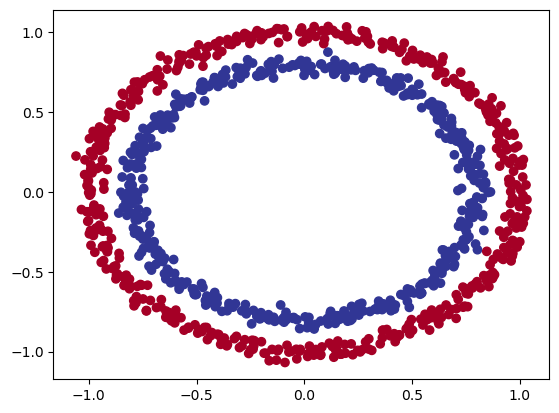

In [5]:
# visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

**Notes** : The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals

### 1.1 check input and output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
[X]

[array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        ...,
        [-0.13690036, -0.81001183],
        [ 0.67036156, -0.76750154],
        [ 0.28105665,  0.96382443]])]

In [8]:
# View the first example of features and examples
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of x : {X_sample} and the same for y : {y_sample}")
print(f"Shapes for one sample of x : {X_sample.shape} and the same for y : {y_sample.shape}")

Values for one sample of x : [0.75424625 0.23148074] and the same for y : 1
Shapes for one sample of x : (2,) and the same for y : ()


### 1.2 Turn data into tensors and create tts

In [9]:
import torch
torch.__version__

'2.5.1+cu124'

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
X.dtype, y.dtype, type(X)

(torch.float32, torch.float32, torch.Tensor)

In [13]:
# Split data into training and tests sets
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)

In [14]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Lets' build a model to classify out blue and red dots

To do so, we want to:
1. Setup device agonotic code so our code will run on an accelerator (GPU) if theres is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [15]:
from torch import nn

# make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Now we've setup device agnostic code, let's create a model that :

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target `device`

In [16]:
y[:5]

tensor([1., 1., 1., 1., 0.])

In [17]:
# 1. construct
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. create 2 nn.Linear layes that capable of handling the shapes of our data
        self.layer1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
        self.layer2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from prevvious layer and outputs a single feature (same shape as y)

    # 3.define a forward() me
    def forward(self, x):
        return self.layer2(self.layer1(x)) # x -> layer 1 -> layer 2 -> outout

# 4. instantiate an instance of our model class and send it into target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [19]:
# let's replicate the model above using nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1),
).to(device)

In [20]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.6409,  0.4249],
                      [ 0.5265, -0.3244],
                      [ 0.1710,  0.4367],
                      [-0.1650,  0.0956],
                      [-0.4774, -0.5638]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.1287,  0.6682, -0.2369, -0.6107, -0.4428], device='cuda:0')),
             ('1.weight',
              tensor([[-0.3547, -0.1897, -0.1169, -0.3866, -0.0717]], device='cuda:0')),
             ('1.bias', tensor([-0.3623], device='cuda:0'))])

In [22]:
# make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions : {len(untrained_preds)}, Shape : {untrained_preds.shape}")
print(f"Length of test samples : {len(X_test)}, Shape : {X_test.shape}")
print(f"\nFirst 10 predictions :\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels :\n{y_test[:10]}")

Length of predictions : 200, Shape : torch.Size([200, 1])
Length of test samples : 200, Shape : torch.Size([200, 2])

First 10 predictions :
tensor([[-0.4096],
        [-0.3673],
        [-0.3406],
        [-0.4299],
        [-0.0548],
        [-0.0312],
        [-0.1384],
        [-0.0590],
        [-0.3527],
        [-0.3613]], device='cuda:0')

First 10 labels :
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [23]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss function and optimizer

Which loss function or optimizer whould u use?

Again.. this is problem specific

For example for regression you  might want MAE or MSE

For classfication you might want binary cross entropy or categorical CE (CE).

As a reminder, the loss function measssures how *wrong* your models predictions are

And form optimizers, 2 of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

* for some common choices of loss functions and optimizers - https://www.learnpytorch.io/02_pytorch_classification/#21-setup-loss-function-and-optimizer
* for the loss function we're going to use `torch.nn.BECWithLogitsLoss()`, for more on that BCE us, check out this article - https://medium.com/towards-data-science/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
* For a definition on what a logit is in deep learning - -https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow
* For different optimizers see `torch.optim`

In [24]:
# setup the loss function
# loss_fn1 = nn.BCELoss() # requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation function built-in

optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [25]:
# calculate accuracy - out of 100 examples, what percentage does our model get right?

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_pred)*100
    return acc

## 3. Train model

To train our model, we're going to need build a training loop with the following steps:
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. loss backward (backprop)
5. opt step (grad des)

### 3.1 Going from raw logits ->  pred's probabilities -> preds labels

Out model outputs are going to be raw **logits**

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function(e.g. sigmoid for binary classification and softmax for multiclass classification)

Then we can convert our model's prediction probabilities to *prediction labels* by either rounding them or taking the `argmax()`

In [26]:
# View the first 5 outputs of theforward pass of the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
    y_logits2 = model_0(X_test.to(device))
print(y_logits)

tensor([[-0.4096],
        [-0.3673],
        [-0.3406],
        [-0.4299],
        [-0.0548]], device='cuda:0')


In [27]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [28]:
# use the sigmoid activation function on our model logits to turn them into preds probabilities
y_pred_probs  = torch.sigmoid(y_logits)
print(y_pred_probs)

tensor([[0.3990],
        [0.4092],
        [0.4157],
        [0.3941],
        [0.4863]], device='cuda:0')


For our pred probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [29]:
# find the predicted labels
y_preds = torch.round(y_pred_probs)

# in full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check for quality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

In [30]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [31]:
print(y_logits2.shape)
print(y_train.shape)
print(X_train.squeeze().shape)

torch.Size([200, 1])
torch.Size([800])
torch.Size([800, 2])


In [32]:
print(X_train[:10])

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        [-0.9666, -0.2256],
        [-0.1666,  0.7994],
        [-0.8837, -0.4678],
        [-0.3836,  0.6987],
        [ 0.6047,  0.5163],
        [-0.5869,  0.7804],
        [ 0.8833, -0.5178]])


### 3.2 Building a training and testing loop

In [33]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    model_0.train()
    #training

    # 1. forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), y_train) # nn.BCELoss expects prediction probabilities as input
    loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. opt zero grad
    optimizer.zero_grad()

    #l 4. loss backward (backprop)
    loss.backward()

    # 5. optimizer step (grad des)
    optimizer.step()

    # testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        # forward pass

        test_pred = torch.round(torch.sigmoid(test_logits))

        #2. calculate the tess loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    #print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch : {epoch}, Loss : {loss:.4f}, Accuracy : {acc:.4f} | Test Loss : {test_loss:.4f} | Test Accuracy : {test_acc:.4f}")


Epoch : 0, Loss : 0.7036, Accuracy : 45.7500 | Test Loss : 0.7021 | Test Accuracy : 46.0000
Epoch : 10, Loss : 0.6985, Accuracy : 46.8750 | Test Loss : 0.6978 | Test Accuracy : 45.0000
Epoch : 20, Loss : 0.6965, Accuracy : 49.2500 | Test Loss : 0.6962 | Test Accuracy : 44.5000
Epoch : 30, Loss : 0.6955, Accuracy : 50.2500 | Test Loss : 0.6955 | Test Accuracy : 44.5000
Epoch : 40, Loss : 0.6949, Accuracy : 50.2500 | Test Loss : 0.6951 | Test Accuracy : 45.0000
Epoch : 50, Loss : 0.6945, Accuracy : 50.0000 | Test Loss : 0.6949 | Test Accuracy : 47.5000
Epoch : 60, Loss : 0.6941, Accuracy : 49.8750 | Test Loss : 0.6947 | Test Accuracy : 47.5000
Epoch : 70, Loss : 0.6939, Accuracy : 49.6250 | Test Loss : 0.6946 | Test Accuracy : 48.5000
Epoch : 80, Loss : 0.6937, Accuracy : 49.3750 | Test Loss : 0.6945 | Test Accuracy : 50.0000
Epoch : 90, Loss : 0.6935, Accuracy : 49.8750 | Test Loss : 0.6945 | Test Accuracy : 49.0000


## 4. Make predictions and evaluate the model
]
From the metrics it looks like out model isn't learning anyhthing...

So to inspect it let's make some predictions and make them visual!

In other words, "visualize, visualize, visualize!"

To do so, we're going to import a function `plot_decision_boundary() - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

raw - https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py


In [34]:
import requests
import numpy as np
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)

if Path("../Python/helper_functions.py").is_file():
    print("Helper functions already exists, skipping download")
else:
    print("Downloading helper functions")
    requests = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("../Python/helper_functions.py", "wb") as f:
        f.write(requests.content)

# from helper_functions import plot_predictions, plot_decision_boundary

Helper functions already exists, skipping download


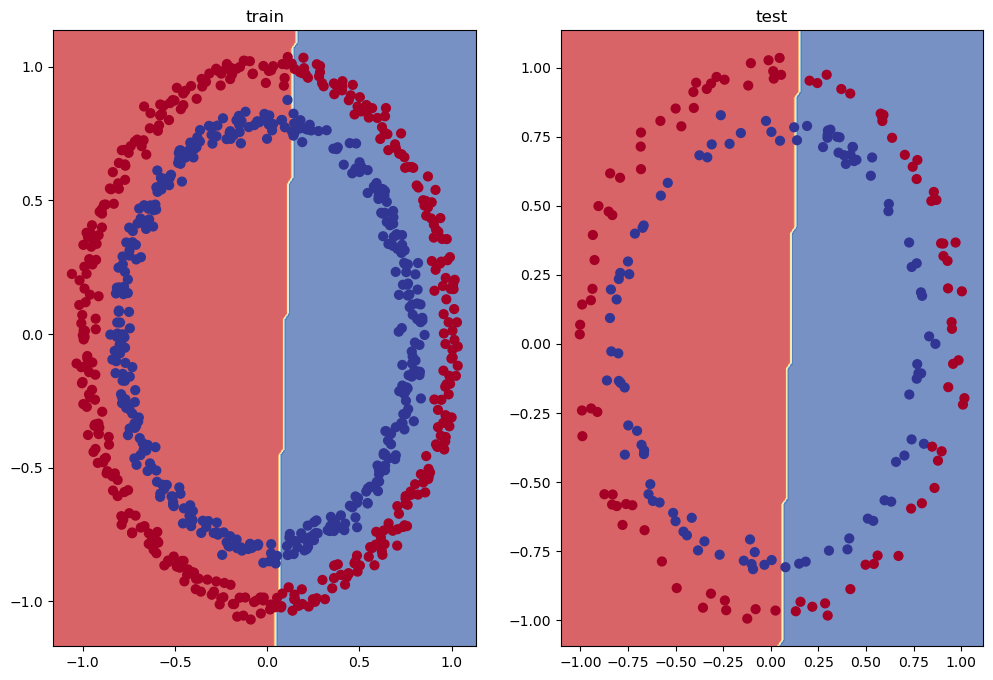

In [35]:
# plot decision boundary of the model

import sys
sys.path.append("../Python")

from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)

plt.title("test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* add more layers - give the model chances to learn about patterns in the data
* add more hidden units - go from 5 hidden units to 10 hidden units
* fit for longer
* changing the activation functions
* change the learning rate
* change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data

And because of these options are all values we (as ml engineers and data scientist) can change, they are referred as **hyperparameters**

Let's try and improve our model by:
- adding more hidden units : 5 -> 10
- increase the number of layers : 2 -> 3
- increase the number of epochs : 100 -> 1000

In [36]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.6035,  0.3925],
                      [ 0.5515, -0.3459],
                      [ 0.1877,  0.4223],
                      [-0.1077,  0.0463],
                      [-0.4622, -0.5768]])),
             ('0.bias', tensor([ 0.0894,  0.6451, -0.2526, -0.6639, -0.4557])),
             ('1.weight',
              tensor([[-0.2107, -0.2165, -0.1226, -0.4412, -0.1315]])),
             ('1.bias', tensor([-0.2346]))])

In [37]:
print(X_train[:5])
print(y_train[:5])

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        [-0.9666, -0.2256],
        [-0.1666,  0.7994]], device='cuda:0')
tensor([1., 0., 0., 0., 1.], device='cuda:0')


In [38]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # z = self.layer1(x)
        # z = self.layer2(z)
        # z = self.layer3(z)
        return self.layer3(self.layer2(self.layer1(x))) # this way of writing operations leverages speed ups where possible behind the scenes

model_yeah = CircleModelV1().to(device)
model_yeah

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [39]:
# create a loss function
loss_func1 = nn.BCEWithLogitsLoss()

# create an optim
opt = torch.optim.SGD(params=model_yeah.parameters(), lr=0.10)

In [40]:
# write a training and evaluation loop for the new model

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# train for longer
epochs = 1000

# put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # training
    model_yeah.train()

    # forward pass
    y_logits = model_yeah(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred proboba -> pred labels

    # calc the loss/acc
    loss = loss_func1(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # opt zero grad
    opt.zero_grad()

    # backprop
    loss.backward()

    # opt (grad desc)
    opt.step()

    ## testing
    model_yeah.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_yeah(X_test).squeeze()

        test_pred = torch.round(torch.sigmoid(test_logits))

        # calc the loss
        test_loss1 = loss_func1(test_logits, y_test)
        test_acc1 = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # print out what is happening
    if epoch % 100 == 0:
        print(f"Epochs : {epoch} | loss : {loss:.5f} | Acc : {acc:.3f} | Test loss : {test_loss:.5f} | Test Acc : {test_acc:.3f}")



Epochs : 0 | loss : 0.69396 | Acc : 50.875 | Test loss : 0.69447 | Test Acc : 50.000
Epochs : 100 | loss : 0.69305 | Acc : 50.375 | Test loss : 0.69447 | Test Acc : 50.000
Epochs : 200 | loss : 0.69299 | Acc : 51.125 | Test loss : 0.69447 | Test Acc : 50.000
Epochs : 300 | loss : 0.69298 | Acc : 51.625 | Test loss : 0.69447 | Test Acc : 50.000
Epochs : 400 | loss : 0.69298 | Acc : 51.125 | Test loss : 0.69447 | Test Acc : 50.000
Epochs : 500 | loss : 0.69298 | Acc : 51.000 | Test loss : 0.69447 | Test Acc : 50.000
Epochs : 600 | loss : 0.69298 | Acc : 51.000 | Test loss : 0.69447 | Test Acc : 50.000
Epochs : 700 | loss : 0.69298 | Acc : 51.000 | Test loss : 0.69447 | Test Acc : 50.000
Epochs : 800 | loss : 0.69298 | Acc : 51.000 | Test loss : 0.69447 | Test Acc : 50.000
Epochs : 900 | loss : 0.69298 | Acc : 51.000 | Test loss : 0.69447 | Test Acc : 50.000


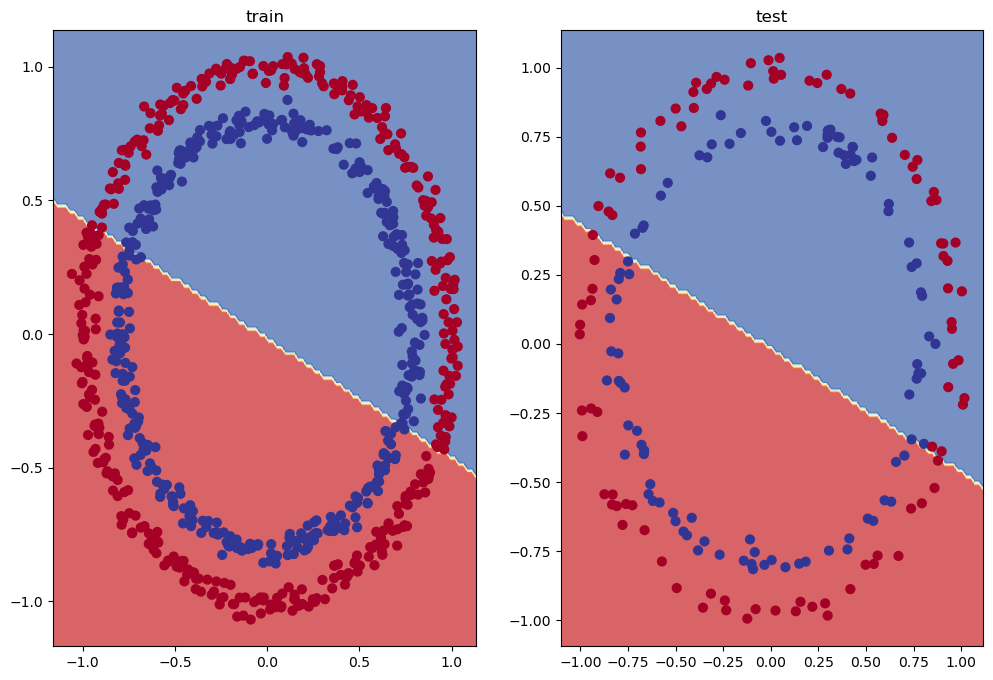

In [41]:
# Plot the decision boundary
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_yeah, X_train, y_train)
plt.subplot(1, 2, 2)

plt.title("test")
plot_decision_boundary(model_yeah, X_test, y_test)

### 5.1 Preparing the data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem

In [42]:
# create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight*X_regression + bias # linear regression formla (without epsilon)

# check the data
print(len(X_regression))
print(len(y_regression))
X_regression[:5], y_regression[:5]

100
100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [43]:
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# check the lengths
print(f"length of x train reg : {len(X_train_regression)}")
print(f"length of y train reg : {len(y_train_regression)}")
print(f"length of x test reg : {len(X_test_regression)}")
print(f"length of y test reg : {len(y_test_regression)}")

length of x train reg : 80
length of y train reg : 80
length of x test reg : 20
length of y test reg : 20


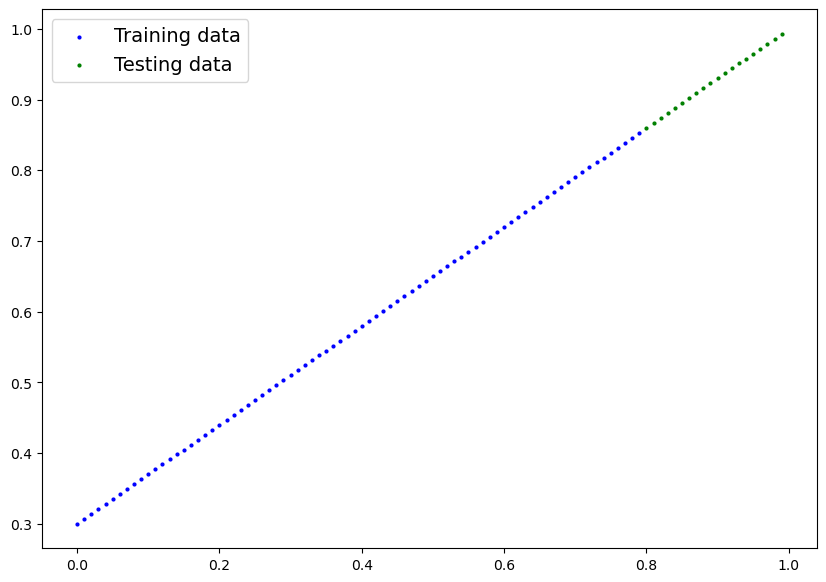

In [44]:
plot_predictions(train_data=X_train_regression, train_labels=y_train_regression, test_data=X_test_regression, test_labels=y_test_regression)

In [45]:
X_train_regression[:10], y_train_regression[:10]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280],
         [0.3350],
         [0.3420],
         [0.3490],
         [0.3560],
         [0.3630]]))

In [46]:
model_yeah

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

### 5.2 Adjusting `model_yeah` to fit a straight line

In [47]:
# Same architecture as model_yeah (but using nn.Sequential())
model_yeah1 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device)

model_yeah1

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [48]:
# loss and optimizer
loss_fn1 = nn.L1Loss()
optim = torch.optim.SGD(params=model_yeah1.parameters(), lr=0.01)

In [49]:
# train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set up the number of epoch
epochs = 1000

# put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# training
for epoch in range(epochs):
    y_pred = model_yeah1(X_train_regression)
    loss = loss_fn1(y_pred, y_train_regression)
    optim.zero_grad()
    loss.backward()
    optim.step()

    # testing
    model_yeah1.eval()
    with torch.inference_mode():
        test_pred = model_yeah1(X_test_regression)
        test_loss = loss_fn1(test_pred, y_test_regression)

    # print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch : {epoch} | Loss : {loss:.5f} | Test Loss : {test_loss:.5f}")


Epoch : 0 | Loss : 0.75986 | Test Loss : 0.91103
Epoch : 100 | Loss : 0.02858 | Test Loss : 0.00081
Epoch : 200 | Loss : 0.02533 | Test Loss : 0.00209
Epoch : 300 | Loss : 0.02137 | Test Loss : 0.00305
Epoch : 400 | Loss : 0.01964 | Test Loss : 0.00341
Epoch : 500 | Loss : 0.01940 | Test Loss : 0.00387
Epoch : 600 | Loss : 0.01903 | Test Loss : 0.00379
Epoch : 700 | Loss : 0.01878 | Test Loss : 0.00381
Epoch : 800 | Loss : 0.01840 | Test Loss : 0.00329
Epoch : 900 | Loss : 0.01798 | Test Loss : 0.00360


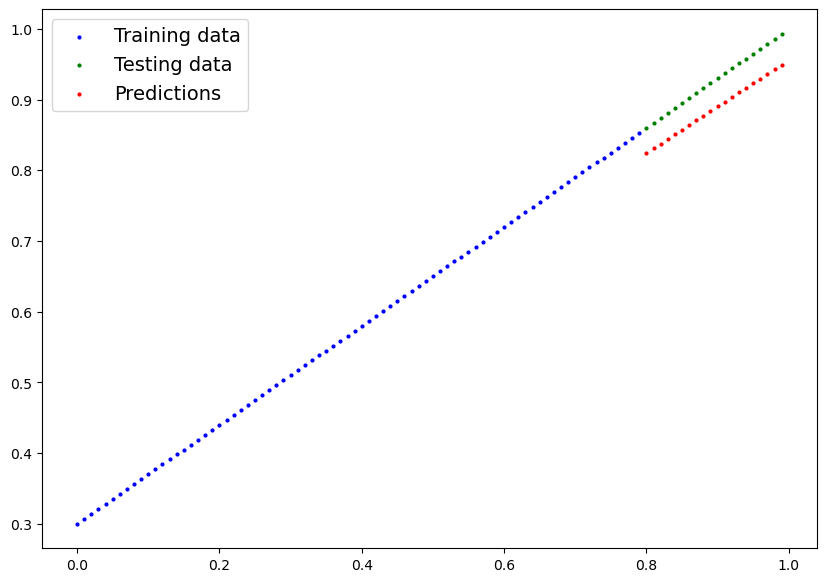

In [50]:
# Turn on evaluation mode
model_yeah1.eval()

# make predictions (inference)
with torch.inference_mode():
    y_preds = model_yeah1(X_test_regression)

X_train_regression = X_train_regression.cpu().numpy()
y_train_regression = y_train_regression.cpu().numpy()
X_test_regression = X_test_regression.cpu().numpy()
y_test_regression = y_test_regression.cpu().numpy()
y_preds = y_preds.cpu().numpy()

# plot data and preds
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression,
                 predictions=y_preds)

## 6. the missing piece of our model: non-linearity

"what patterns could you draw if you were given an infinite amount of a straight and non-straight lines?"

Or in ML terms, an infinite (but really it is finite) of linear and non-linear functions?

### 6.1 Recreateing non-linear data (red and blue circles)

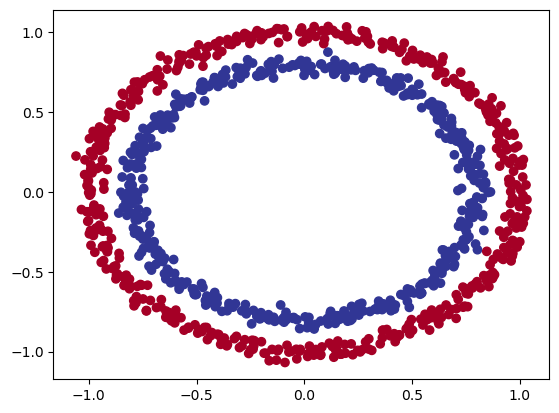

In [51]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [52]:
# convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 building a model with non-linearitty

- Linear = straight lines
- non-linear = non straight lines

artificial neural networks are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to find patterns in data

In [53]:
# build a model with a non-linear activation functions
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # relu is a non-linear activation function

    def forward(self, x):
        # where should we put our non-linear activation functions?
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model3 = CircleModelV2().to(device)
model3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [54]:
# setup loss and optimizer
loss_function = nn.BCEWithLogitsLoss()

optmizerrrr = torch.optim.SGD(model3.parameters(), lr=0.01)

## 6.3 train a model with non-linearity


In [55]:
# random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [56]:
len(X_test), len(y_test)

(200, 200)

In [57]:
# loop through data
epochs = 1000

for epoch in range(epochs):
    ### Training
    model3.train()

    # 1. forward pass
    y_logits = model3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate the loss
    loss = loss_function(y_logits, y_train) # BCEwithLogitsLoss (takes in logits as first input)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. optimizer zero grad
    optmizerrrr.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optmizerrrr.step()

    # testing
    model3.eval()
    with torch.inference_mode():
        test_logits = model3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # print(test_logits.shape, y_test.shape)

        test_loss = loss_function(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch : {epoch} | Loss : {loss:.4f} | acc : {acc:.4f} | test loss : {test_loss:.4f} | test acc : {test_acc:.4f}")

Epoch : 0 | Loss : 0.6929 | acc : 50.0000 | test loss : 0.6932 | test acc : 50.0000
Epoch : 100 | Loss : 0.6925 | acc : 50.3750 | test loss : 0.6926 | test acc : 50.0000
Epoch : 200 | Loss : 0.6922 | acc : 59.0000 | test loss : 0.6923 | test acc : 56.0000
Epoch : 300 | Loss : 0.6921 | acc : 70.1250 | test loss : 0.6921 | test acc : 67.0000
Epoch : 400 | Loss : 0.6919 | acc : 68.3750 | test loss : 0.6920 | test acc : 70.0000
Epoch : 500 | Loss : 0.6918 | acc : 58.5000 | test loss : 0.6918 | test acc : 62.0000
Epoch : 600 | Loss : 0.6917 | acc : 54.0000 | test loss : 0.6916 | test acc : 56.0000
Epoch : 700 | Loss : 0.6915 | acc : 53.2500 | test loss : 0.6915 | test acc : 53.0000
Epoch : 800 | Loss : 0.6914 | acc : 52.6250 | test loss : 0.6913 | test acc : 53.0000
Epoch : 900 | Loss : 0.6913 | acc : 52.7500 | test loss : 0.6912 | test acc : 53.0000


### 6.4 Evaluating a model trained with non-linear activation functions

In [58]:
# make predictions
model3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model3(X_test))) .squeeze()
y_preds[:10], y_test[:10]

(tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

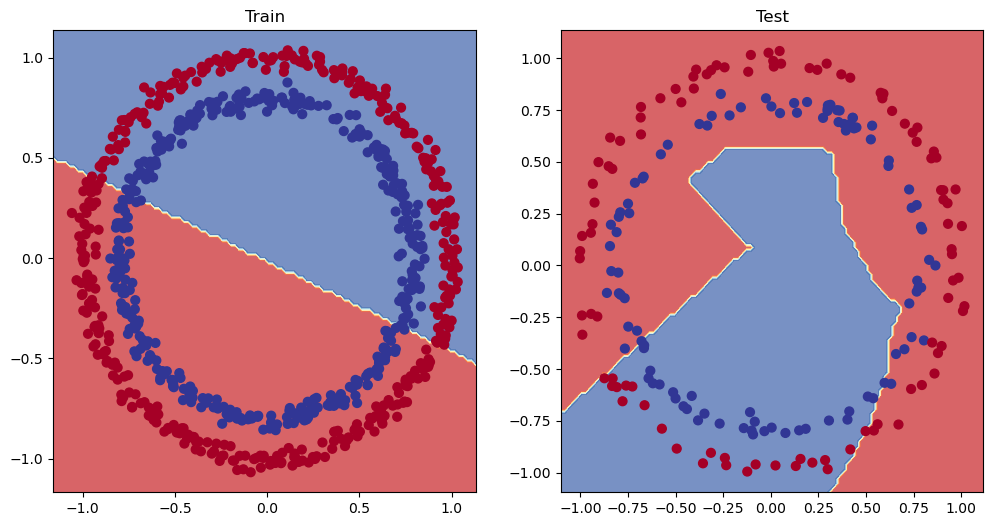

In [59]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_yeah, X_train, y_train) # model yeah = has no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model3, X_test, y_test) # model 3 = has non-linearity

**Challenge** : can you improve model_3 to do better than 80% accuracy on the test data??

In [60]:
# part of myself trying to improve the model
# model_coba_sendiri

class Modelku(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # relu is a non-linear activation function

    def forward(self, x):
        # where should we put our non-linear activation functions?
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
        # return self.layer2(self.relu(self.layer1(x)))

modelku = Modelku().to(device)
modelku

Modelku(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [61]:
# random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# put all data on target device
X_train1, y_train1 = X_train.to(device), y_train.to(device)
X_test1, y_test1 = X_test.to(device), y_test.to(device)

In [62]:
epochs = 1000

for epoch in range(epochs):
    ### Training
    modelku.train()

    # 1. forward pass
    y_logits = modelku(X_train1).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate the loss
    loss = loss_function(y_logits, y_train1) # BCEwithLogitsLoss (takes in logits as first input)
    acc = accuracy_fn(y_true=y_train1, y_pred=y_pred)

    # 3. optimizer zero grad
    optmizerrrr.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optmizerrrr.step()

    # testing
    model3.eval()
    with torch.inference_mode():
        test_logits = modelku(X_test1).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # print(test_logits.shape, y_test.shape)

        test_loss = loss_function(test_logits, y_test1)
        test_acc = accuracy_fn(y_true=y_test1, y_pred=test_pred)

    # print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch : {epoch} | Loss : {loss:.4f} | acc : {acc:.4f} | test loss : {test_loss:.4f} | test acc : {test_acc:.4f}")

Epoch : 0 | Loss : 0.6929 | acc : 50.0000 | test loss : 0.6933 | test acc : 50.0000
Epoch : 100 | Loss : 0.6929 | acc : 50.0000 | test loss : 0.6933 | test acc : 50.0000
Epoch : 200 | Loss : 0.6929 | acc : 50.0000 | test loss : 0.6933 | test acc : 50.0000
Epoch : 300 | Loss : 0.6929 | acc : 50.0000 | test loss : 0.6933 | test acc : 50.0000
Epoch : 400 | Loss : 0.6929 | acc : 50.0000 | test loss : 0.6933 | test acc : 50.0000
Epoch : 500 | Loss : 0.6929 | acc : 50.0000 | test loss : 0.6933 | test acc : 50.0000
Epoch : 600 | Loss : 0.6929 | acc : 50.0000 | test loss : 0.6933 | test acc : 50.0000
Epoch : 700 | Loss : 0.6929 | acc : 50.0000 | test loss : 0.6933 | test acc : 50.0000
Epoch : 800 | Loss : 0.6929 | acc : 50.0000 | test loss : 0.6933 | test acc : 50.0000
Epoch : 900 | Loss : 0.6929 | acc : 50.0000 | test loss : 0.6933 | test acc : 50.0000


In [63]:
# make predictions
modelku.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(modelku(X_test))) .squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

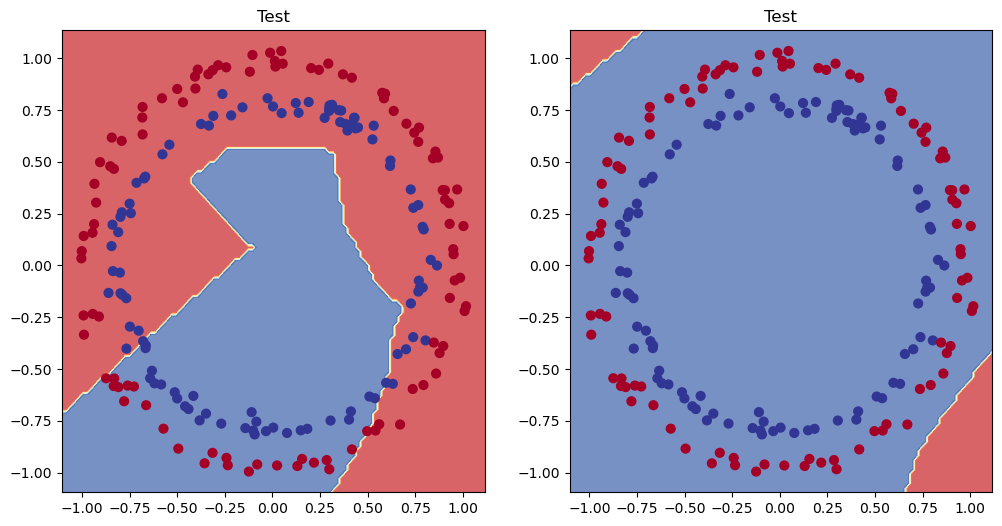

In [64]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Test")
plot_decision_boundary(model3, X_test, y_test) # model 3 = has non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(modelku, X_test, y_test) # model yeah = has no non-linearity

In [65]:
# # setup loss and optimizer
# loss_function = nn.BCEWithLogitsLoss()
#
# optmizerrrr = torch.optim.SGD(model3.parameters(), lr=0.1)

# # random seeds
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)
#
# # put all data on target device
# X_train, y_train = X_train.to(device), y_train.to(device)
# X_test, y_test = X_test.to(device), y_test.to(device)

done of my experiment

## 7. replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patters in data and it tries to figure out the patterns on its own

and these tools are linear and non-linear functions

In [66]:
# create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [67]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

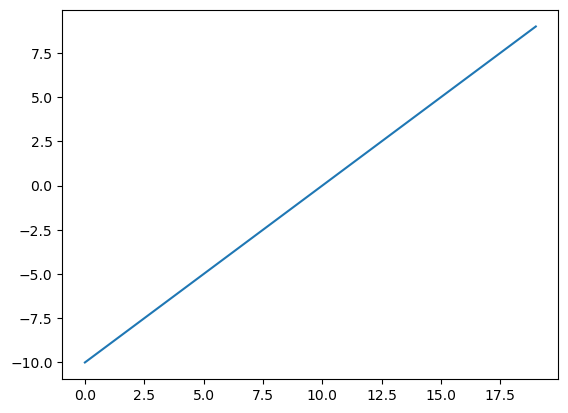

In [68]:
# visualize the tensor
plt.plot(A);

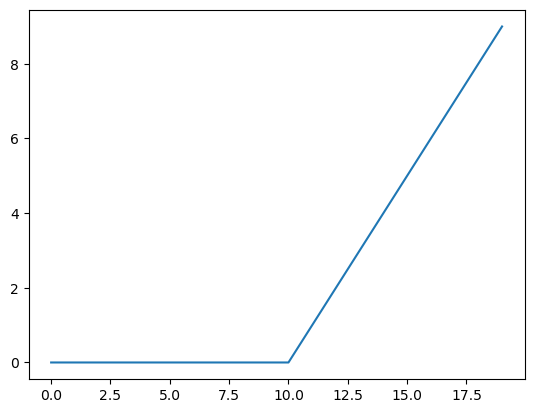

In [69]:
plt.plot(torch.relu(A))

In [70]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x) # input must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

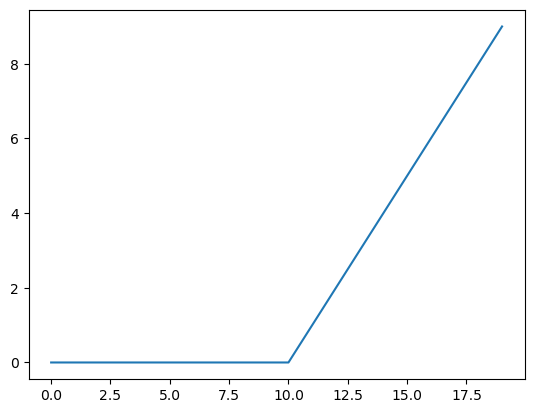

In [71]:
# plot relu activation function

plt.plot(relu(A))

In [72]:
# now let's do the same for sigmoid

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

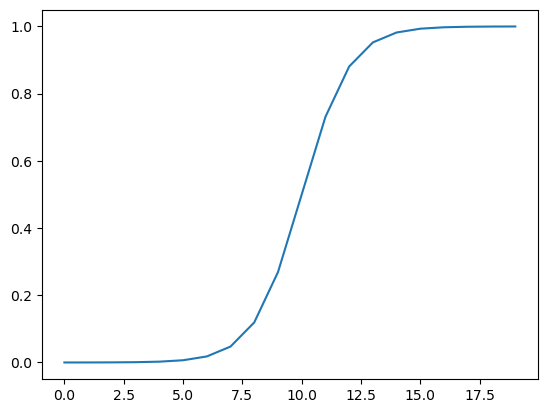

In [73]:
plt.plot(sigmoid(A))

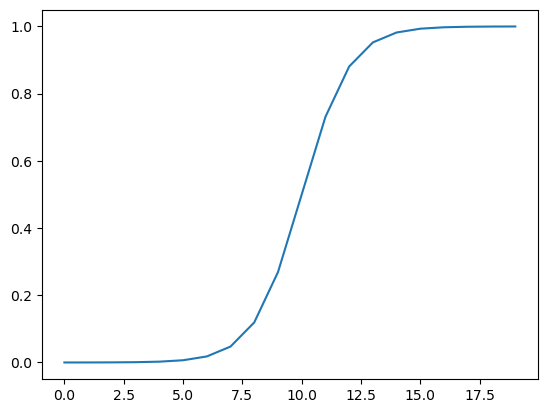

In [74]:
plt.plot(torch.sigmoid(A))

## 8. putting it all together with a multi-class classification problem

- binary classification = one thing or another (cat vs dog, spam vs not spam)
- multi class classif = more than one thing or another (cat vs dog vs chicken)

### 8.1 creating a toy multi class dataset

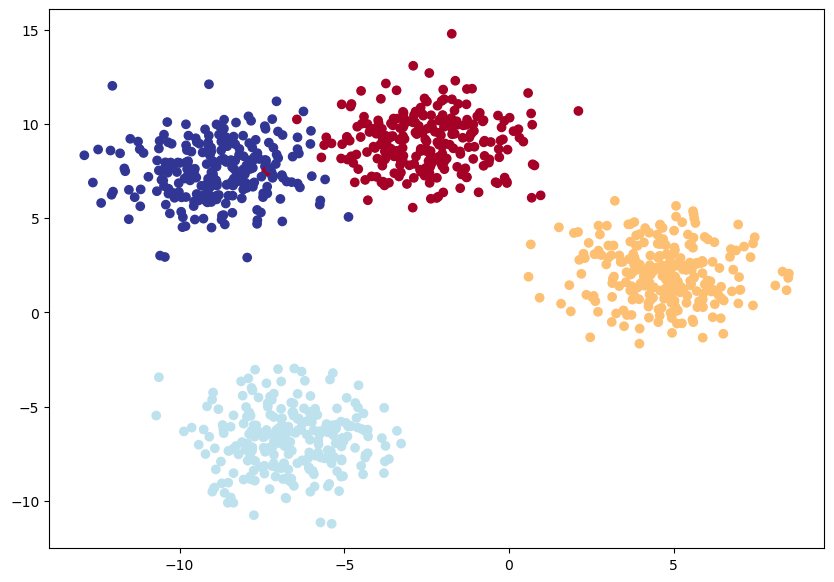

In [75]:
# import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
from sklearn.model_selection import train_test_split

# set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. create a multi class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the classes a little shaker
                            random_state=RANDOM_SEED
                            )

# 2. turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. splitting the data
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# 4. plot data (visualize, visualize, visualize)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi class classification in pytorch

In [76]:
# create device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [77]:
# building a multi-class classificatin model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        initialize multi-class classification model
        Args :
        :param input_features (int): Number of input features to the model
        :param output_features (int): Number of output features (number of output classes)
        :param hidden_features (int): Number of hidden unites between layers, default 8

        Returns :

        Example:
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [78]:
X_train.shape, y_train[:5]

(torch.Size([800, 2]), tensor([1., 0., 0., 0., 1.], device='cuda:0'))

In [79]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

### 8.3 Create a loss func and optimizer for a multi-class classification model

In [80]:
# create a loss func for multi-class classification - loss func measures how wrong the model predictions are
loss_fn = nn.CrossEntropyLoss()

#Create an optimizer for multi class classification - optimizer updates our model parameters to try and reduce the loss
optimizer = torch.optim.Adam(params=model_4.parameters(),
                             lr=0.1) # lr is a hyperparameter you can change

### 8.4 getting prediction probability for a multi-class PyTorch model

in order to evaluate train and test our model we need to convert out model's outputs (logits) to prediction probabilities and the to prediction labels.

Logits (raw outputs of the model) -> pred probs (use `torch.softmax`) -> pred labels (take the argmax of the prediction probabilities)

In [81]:
# let's hey some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [82]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [83]:
# convert out model's logit outputs to prediction probabilities

y_pred_probs = torch.softmax(y_logits, dim=1)

print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [84]:
# convert our models pred probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [85]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 create a training and testing loop for multi class pytorch model

In [86]:
# fi rthe multi class model tu the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
epochs = 100

# put the data to the device

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data

for epoch in range(epochs):
    model_4.train()

    # forward pass
    y_logits = model_4(X_blob_train)

    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # calculate the loss
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # loss backward (backprop)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)

        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred=test_preds)

    # printing out what is happening
    if epoch % 10 == 0:
        print(f"Epoch : {epoch} | loss : {loss:.4f}, Acc : {acc:.2f}% | test loss : {test_loss:.4f} | test acc : {test_acc:.2f}")

Epoch : 0 | loss : 1.1588, Acc : 40.38% | test loss : 0.8167 | test acc : 68.50
Epoch : 10 | loss : 0.0397, Acc : 98.75% | test loss : 0.0195 | test acc : 99.50
Epoch : 20 | loss : 0.0316, Acc : 99.25% | test loss : 0.0044 | test acc : 100.00
Epoch : 30 | loss : 0.0222, Acc : 99.12% | test loss : 0.0061 | test acc : 99.50
Epoch : 40 | loss : 0.0200, Acc : 99.50% | test loss : 0.0069 | test acc : 99.50
Epoch : 50 | loss : 0.0187, Acc : 99.50% | test loss : 0.0084 | test acc : 99.50
Epoch : 60 | loss : 0.0178, Acc : 99.50% | test loss : 0.0069 | test acc : 100.00
Epoch : 70 | loss : 0.0172, Acc : 99.38% | test loss : 0.0053 | test acc : 100.00
Epoch : 80 | loss : 0.0166, Acc : 99.38% | test loss : 0.0044 | test acc : 100.00
Epoch : 90 | loss : 0.0162, Acc : 99.38% | test loss : 0.0047 | test acc : 100.00


### 8.6 Making adn evaluating predictons with pytorch multi class model

In [87]:
# Make predictions
model_4.eval()

with torch.inference_mode():
    y_logits = model_4(X_blob_test)

#view the first 1- predictions
y_logits1 = y_logits.to('cpu')
y_logits1 = y_logits1.numpy()


In [88]:
y_logits1[:10].tolist()

[[-18.32369613647461,
  21.50631332397461,
  -52.04466247558594,
  -39.162506103515625],
 [0.276142418384552,
  -18.812828063964844,
  -25.650663375854492,
  6.765895843505859],
 [-44.41270446777344,
  -50.467315673828125,
  38.56874465942383,
  -8.03573989868164],
 [-22.67778205871582,
  24.157142639160156,
  -40.009674072265625,
  -36.00143814086914],
 [9.610403060913086,
  -8.19849967956543,
  -36.778228759765625,
  -11.907837867736816],
 [-0.6148343086242676,
  -22.572477340698242,
  -30.32828140258789,
  9.14125919342041],
 [-43.476131439208984,
  -49.22697448730469,
  37.61958312988281,
  -7.875951766967773],
 [8.31790542602539,
  -12.478053092956543,
  -29.882814407348633,
  -4.9878411293029785],
 [-49.203514099121094,
  -56.01493835449219,
  42.806941986083984,
  -8.907870292663574],
 [8.62337589263916,
  -10.510300636291504,
  -31.80649757385254,
  -7.590995788574219]]

In [89]:
# go form logits -> prediction probs

y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10].to('cpu').numpy().tolist()

[[5.035547178519649e-18, 1.0, 1.1408155042315038e-32, 4.4860743972510216e-27],
 [0.0015166201628744602,
  7.773957692858158e-12,
  8.336981075656759e-15,
  0.9984833598136902],
 [9.154111137660585e-37, 2.1484834171889885e-39, 1.0, 5.753465655825738e-21],
 [4.569319046555216e-21, 1.0, 1.3573930173916933e-28, 7.47240403564837e-27],
 [1.0, 1.8437065207876913e-08, 7.139575197117044e-21, 4.515920692949038e-10],
 [5.793713717139326e-05,
  1.6860622801899948e-14,
  7.220571236358073e-18,
  0.9999420642852783],
 [6.033606446876297e-36, 1.9187538462983458e-38, 1.0, 1.7439715426332575e-20],
 [0.9999983310699463,
  9.298841141536229e-10,
  2.5682459168501563e-17,
  1.6648964447085746e-06],
 [1.0974128793513372e-40, 1.2051166793193427e-43, 1.0, 3.471698588875875e-23],
 [0.9999998807907104,
  4.901735017881492e-09,
  2.7639398512186147e-18,
  9.082140195459942e-08]]

In [90]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

In [91]:
# Go form pred pribs to pred labels

y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

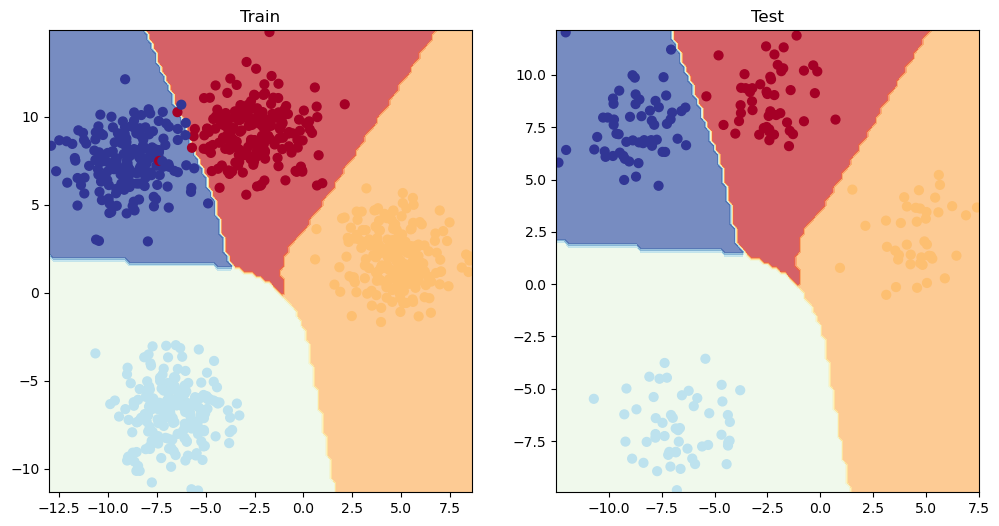

In [92]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy - out of 100 samples, how many does our model correct? Default metric for classification problems. Not the best for imbalanced classes
* Precision - Higher precision leads to less false positives.
* Recall - Higher recall leads to less false negatives.
* F1 score - Combination of precision and recall. usually a good overral metric to use a classfication model.
* Confussion martix - When comparing predictions to truth labels to see where model gets confused. Can be hard to use with large number of classes.
* Classification report

Extra's : https://medium.com/data-science/beyond-accuracy-precision-and-recall-3da06bea9f6c

 If you want to see a lot of pytorch metrics -> https://lightning.ai/docs/torchmetrics/stable/all-metrics.html



In [93]:
# install torchmetrics from terminal
from torchmetrics import Accuracy

# setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(1., device='cuda:0')

# Exercise

exercise -> https://www.learnpytorch.io/02_pytorch_classification/#exercises

Set up device agnostic code

In [94]:
device_now = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device : {device_now}")

Device : cuda


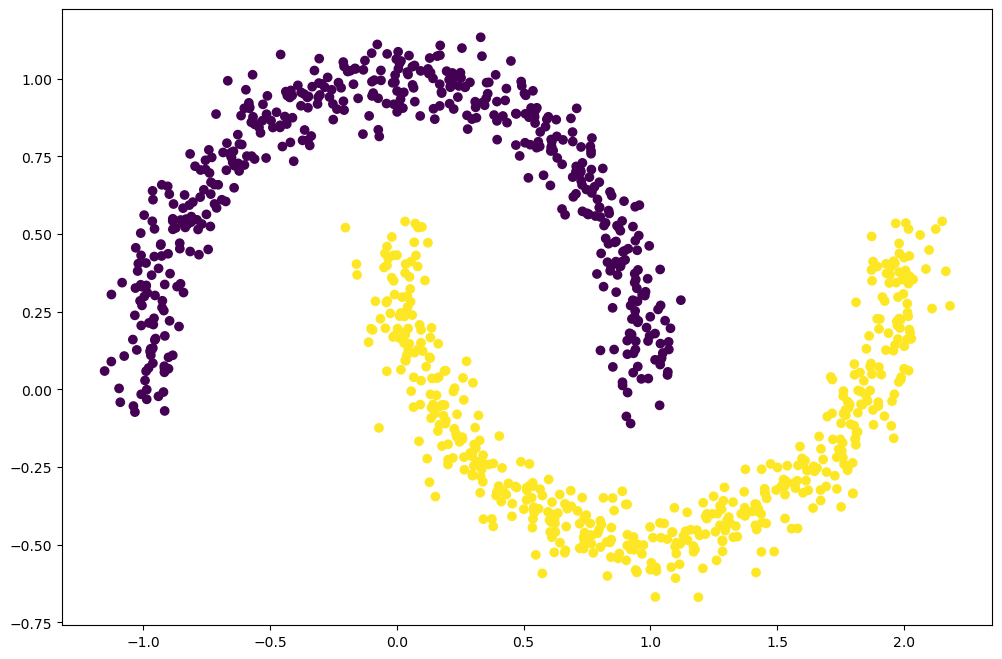

In [95]:
from sklearn.datasets import make_moons

SAMPLES = 1000
RANDOM_SEED = 42

X_moons, y_moons = make_moons(n_samples=SAMPLES, random_state=RANDOM_SEED, noise=0.07)

X_moons = torch.from_numpy(X_moons).type(torch.float)
y_moons = torch.from_numpy(y_moons).type(torch.float)

X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(X_moons, y_moons, test_size=0.2, random_state=RANDOM_SEED)

plt.figure(figsize=(12,8))
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)

In [96]:
# class BlobModel(nn.Module):
#     def __init__(self, input_features, output_features, hidden_units=8):
#         """
#         initialize multi-class classification model
#         Args :
#         :param input_features (int): Number of input features to the model
#         :param output_features (int): Number of output features (number of output classes)
#         :param hidden_features (int): Number of hidden unites between layers, default 8
#
#         Returns :
#
#         Example:
#         """
#         super().__init__()
#         self.linear_layer_stack = nn.Sequential(
#             nn.Linear(in_features=input_features, out_features=hidden_units),
#             nn.ReLU(),
#             nn.Linear(in_features=hidden_units, out_features=hidden_units),
#             nn.ReLU(),
#             nn.Linear(in_features=hidden_units, out_features=output_features)
#         )
#
#     def forward(self, x):
#         return self.linear_layer_stack(x)
#
# # create an instance of BlobModel and send it to the target device
# model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
#
# model_4

In [116]:
class Mun(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

model_aing = Mun(input_features=2, output_features=1, hidden_units=20).to(device)
model_aing

Mun(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [117]:
model_aing.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[-0.6972,  0.0531],
                      [ 0.2285, -0.2121],
                      [ 0.2460, -0.6046],
                      [ 0.4900,  0.6028],
                      [ 0.3899,  0.1198],
                      [ 0.2329, -0.5116],
                      [-0.1767, -0.0675],
                      [-0.3935, -0.5223],
                      [ 0.4756,  0.4799],
                      [-0.6422,  0.2250],
                      [ 0.2877,  0.6717],
                      [ 0.4091,  0.6501],
                      [-0.2315,  0.4952],
                      [ 0.5752, -0.6677],
                      [-0.5676,  0.1431],
                      [ 0.3861, -0.3513],
                      [ 0.0779, -0.0010],
                      [ 0.1790, -0.3800],
                      [ 0.3988,  0.4702],
                      [-0.4906,  0.0069]], device='cuda:0')),
             ('linear_layer_stack.0.bias',
              tensor([ 0.0020,  0.2271,  0.6587,  0.

In [118]:
mine_loss_f = nn.BCEWithLogitsLoss()
mine_opt = torch.optim.Adam(params=model_aing.parameters(), lr=0.01)

In [119]:
# What's coming out from the model
print("Logits : ")
print(model_aing(X_moons_train.to(device)[:10]).squeeze())

Logits : 
tensor([-0.1609, -0.1709, -0.1640, -0.1641, -0.1612, -0.1648, -0.1606, -0.1622,
        -0.1617, -0.1705], device='cuda:0', grad_fn=<SqueezeBackward0>)


In [120]:
print("Pred probs : ")
print(torch.sigmoid(model_aing(X_moons_train.to(device)[:10]).squeeze()))

Pred probs : 
tensor([0.4599, 0.4574, 0.4591, 0.4591, 0.4598, 0.4589, 0.4599, 0.4595, 0.4597,
        0.4575], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [121]:
print("Pred labels : ")
print(torch.round(torch.sigmoid(model_aing(X_moons_train.to(device)[:10]).squeeze())))

Pred labels : 
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<RoundBackward0>)


In [122]:
acc_fn = Accuracy(task="binary", num_classes=2).to(device)
acc_fn

BinaryAccuracy()

In [104]:
# # loop through data
# epochs = 1000
#
# for epoch in range(epochs):
#     ### Training
#     model3.train()
#
#     # 1. forward pass
#     y_logits = model3(X_train).squeeze()
#     y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
#
#     # 2. Calculate the loss
#     loss = loss_function(y_logits, y_train) # BCEwithLogitsLoss (takes in logits as first input)
#     acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
#
#     # 3. optimizer zero grad
#     optmizerrrr.zero_grad()
#
#     # 4. Loss backward
#     loss.backward()
#
#     # 5. Step the optimizer
#     optmizerrrr.step()
#
#     # testing
#     model3.eval()
#     with torch.inference_mode():
#         test_logits = model3(X_test).squeeze()
#         test_pred = torch.round(torch.sigmoid(test_logits))
#         # print(test_logits.shape, y_test.shape)
#
#         test_loss = loss_function(test_logits, y_test)
#         test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
#
#     # print out what's happening
#     if epoch % 100 == 0:
#         print(f"Epoch : {epoch} | Loss : {loss:.4f} | acc : {acc:.4f} | test loss : {test_loss:.4f} | test acc : {test_acc:.4f}")

In [123]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_moons_train, y_moons_train = X_moons_train.to(device), y_moons_train.to(device)
X_moons_test, y_moons_test = X_moons_test.to(device), y_moons_test.to(device)

# training loop

for epoch in range(epochs):
    # training
    model_aing.train()

    # 1) forward pass
    y_logits = model_aing(X_moons_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2) calculate the loss
    loss = mine_loss_f(y_logits, y_moons_train)
    acc = accuracy_fn(y_true= y_moons_train, y_pred=y_pred)

    # 3) optimizer zero grad
    mine_opt.zero_grad()

    # 4) loss backward
    loss.backward()

    # 5) Step the optimizer
    mine_opt.step()

    # testing
    model_aing.eval()
    with torch.inference_mode():
        test_logits = model_aing(X_moons_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = mine_loss_f(test_logits, y_moons_test)
        test_acc = accuracy_fn(y_true=y_moons_test, y_pred=test_pred)

    # print out what is happening
    if epoch % 10 == 0:
        print(f"Epoch : {epoch} | Loss : {loss:.4f} | acc : {acc:.2f}% | test loss : {test_loss:.4f} | test acc : {test_acc:.2f}%")

Epoch : 0 | Loss : 0.6954 | acc : 50.00% | test loss : 0.6894 | test acc : 68.00%
Epoch : 10 | Loss : 0.6260 | acc : 84.75% | test loss : 0.6156 | test acc : 81.50%
Epoch : 20 | Loss : 0.3857 | acc : 84.00% | test loss : 0.3814 | test acc : 85.00%
Epoch : 30 | Loss : 0.2520 | acc : 88.25% | test loss : 0.2335 | test acc : 89.50%
Epoch : 40 | Loss : 0.2130 | acc : 90.00% | test loss : 0.2063 | test acc : 88.00%
Epoch : 50 | Loss : 0.1719 | acc : 92.00% | test loss : 0.1656 | test acc : 91.00%
Epoch : 60 | Loss : 0.1351 | acc : 94.12% | test loss : 0.1280 | test acc : 94.50%
Epoch : 70 | Loss : 0.0813 | acc : 97.12% | test loss : 0.0697 | test acc : 97.50%
Epoch : 80 | Loss : 0.0317 | acc : 99.50% | test loss : 0.0260 | test acc : 100.00%
Epoch : 90 | Loss : 0.0105 | acc : 100.00% | test loss : 0.0080 | test acc : 100.00%


In [106]:
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.title("Train")
# plot_decision_boundary(model_yeah, X_train, y_train) # model yeah = has no non-linearity
# plt.subplot(1, 2, 2)
# plt.title("Test")
# plot_decision_boundary(model3, X_test, y_test) # model 3 = has non-linearity

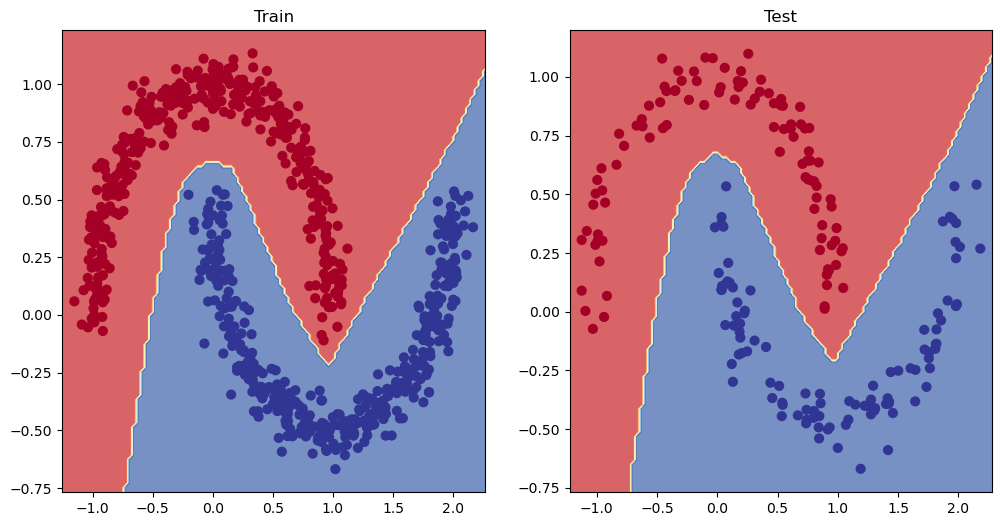

In [124]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_aing, X_moons_train, y_moons_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_aing, X_moons_test, y_moons_test) # ANJAY PERFECTO TERAKHIR SMPE SINI

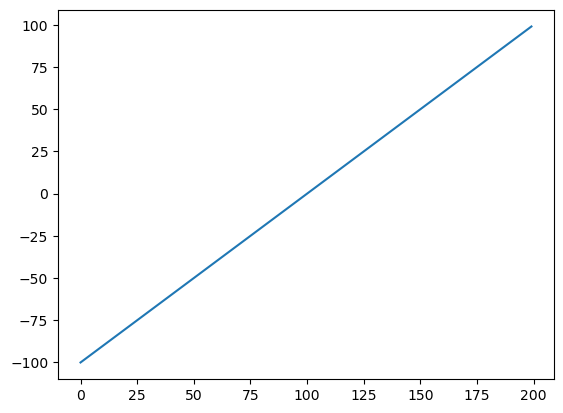

In [108]:
tensor_A = torch.arange(-100, 100, 1)
plt.plot(tensor_A)

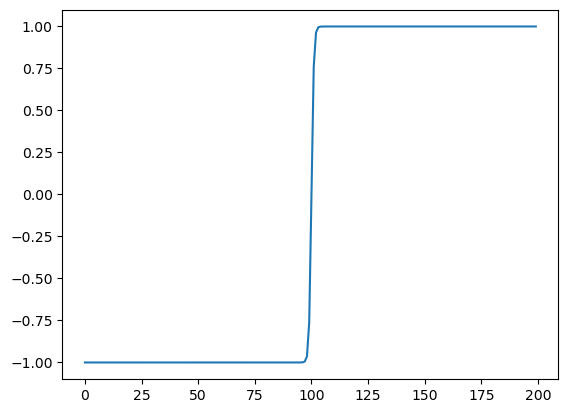

In [109]:
plt.plot(torch.tanh(tensor_A))

In [110]:
def tanh(e):
    return (torch.exp(e) - torch.exp(-e)) / (torch.exp(e) + torch.exp(-e))

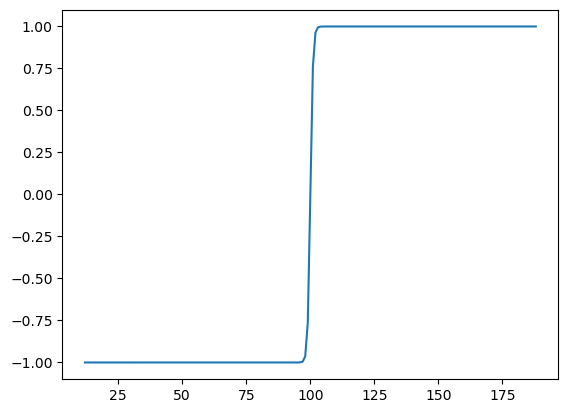

In [111]:
plt.plot(tanh(tensor_A))

test

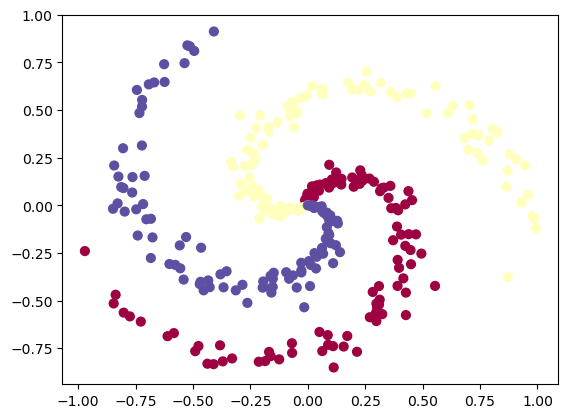

In [259]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [260]:
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)

(240, 60, 240, 60)

In [261]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class SpiralModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
        nn.ReLU()
    )

  def forward(self, x):
    return self.stack(x)

model_ku = SpiralModel(input_features=2, output_features=3, hidden_units=20).to(device)
model_ku

SpiralModel(
  (stack): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=3, bias=True)
    (5): ReLU()
  )
)

In [262]:
v2_loss_function = torch.nn.CrossEntropyLoss()
v2_optimizer = torch.optim.Adam(params=model_ku.parameters(), lr=0.02)
v2_acc_fn = Accuracy(task="multiclass", num_classes=3).to(device)

In [263]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

# Print out untrained model outputs
print("Logits:")
print(model_ku(X_train)[:10])

print("Pred probs:")
print(torch.softmax(model_ku(X_train)[:10], dim=1))

print("Pred labels:")
print(torch.softmax(model_ku(X_train)[:10], dim=1).argmax(dim=1))

torch.float32 torch.float32 torch.int64 torch.int64
Logits:
tensor([[0.0000, 0.0066, 0.0764],
        [0.0000, 0.0134, 0.0924],
        [0.0000, 0.0101, 0.0481],
        [0.0000, 0.0606, 0.0984],
        [0.0000, 0.0529, 0.0733],
        [0.0000, 0.0228, 0.0706],
        [0.0000, 0.0189, 0.0664],
        [0.0000, 0.0092, 0.0269],
        [0.0000, 0.0210, 0.0972],
        [0.0000, 0.0583, 0.1105]], device='cuda:0', grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.3240, 0.3262, 0.3498],
        [0.3215, 0.3259, 0.3526],
        [0.3269, 0.3302, 0.3430],
        [0.3159, 0.3356, 0.3485],
        [0.3195, 0.3368, 0.3438],
        [0.3230, 0.3304, 0.3466],
        [0.3239, 0.3300, 0.3461],
        [0.3293, 0.3324, 0.3383],
        [0.3202, 0.3270, 0.3528],
        [0.3148, 0.3337, 0.3516]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')


In [264]:
# for epoch in range(epochs):
#     model_4.train()
#
#     # forward pass
#     y_logits = model_4(X_blob_train)
#
#     y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
#
#     # calculate the loss
#     loss = loss_fn(y_logits, y_blob_train)
#     acc = accuracy_fn(y_true=y_blob_train,
#                       y_pred=y_pred)
#
#     # loss backward (backprop)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#
#     #Testing
#     model_4.eval()
#     with torch.inference_mode():
#         test_logits = model_4(X_blob_test)
#         test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
#
#         test_loss = loss_fn(test_logits, y_blob_test)
#
#         test_acc = accuracy_fn(y_true=y_blob_test,
#                                y_pred=test_preds)
#
#     # printing out what is happening
#     if epoch % 10 == 0:
#         print(f"Epoch : {epoch} | loss : {loss:.4f}, Acc : {acc:.2f}% | test loss : {test_loss:.4f} | test acc : {test_acc:.2f}")

In [265]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
    # training
    model_ku.train()

    # forward pass
    y_logits = model_ku(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # calculate the loss
    loss = v2_loss_function(y_logits, y_train)
    acc = v2_acc_fn(y_pred, y_train)

    # loss backward (backprop)
    v2_optimizer.zero_grad()
    loss.backward()
    v2_optimizer.step()

    # testing
    model_ku.eval()
    with torch.inference_mode():
        test_logits = model_ku(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = v2_loss_function(test_logits, y_test)
        test_acc = v2_acc_fn(test_preds, y_test)

    # print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch : {epoch} | Loss : {loss:.4f} | Acc : {acc:.2f}% | test loss : {test_loss:.4f} | test acc : {test_acc:.2f}%")

Epoch : 0 | Loss : 1.1007 | Acc : 0.28% | test loss : 1.0898 | test acc : 0.27%
Epoch : 100 | Loss : 0.0921 | Acc : 0.97% | test loss : 0.0576 | test acc : 1.00%
Epoch : 200 | Loss : 0.0319 | Acc : 0.99% | test loss : 0.0068 | test acc : 1.00%
Epoch : 300 | Loss : 0.0229 | Acc : 0.99% | test loss : 0.0020 | test acc : 1.00%
Epoch : 400 | Loss : 0.0191 | Acc : 0.99% | test loss : 0.0008 | test acc : 1.00%
Epoch : 500 | Loss : 0.0170 | Acc : 0.99% | test loss : 0.0003 | test acc : 1.00%
Epoch : 600 | Loss : 0.0158 | Acc : 0.99% | test loss : 0.0001 | test acc : 1.00%
Epoch : 700 | Loss : 0.0152 | Acc : 0.99% | test loss : 0.0001 | test acc : 1.00%
Epoch : 800 | Loss : 0.0148 | Acc : 0.99% | test loss : 0.0000 | test acc : 1.00%
Epoch : 900 | Loss : 0.0146 | Acc : 0.99% | test loss : 0.0000 | test acc : 1.00%


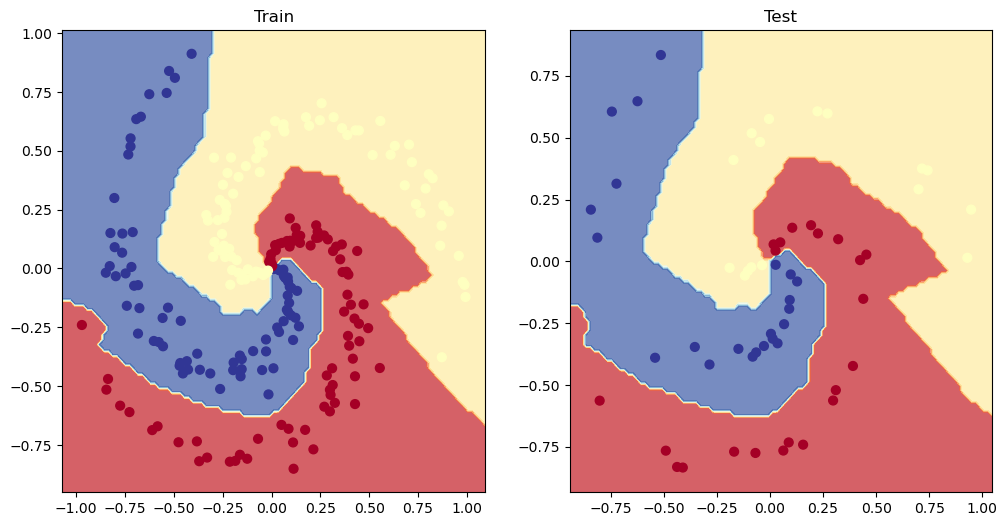

In [266]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_ku, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_ku, X_test, y_test)

yey kelar